<h1 style="text-align: center">
Deep Learning HW2 </br> 
Image Classification
</h1>

### Full Name: Mahdi Shafiei
### Student ID: 99109409

## Import needed libraries


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import copy
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report
from torch.autograd import Variable

## Loading and Pre-Processing data

In [69]:
## Download FashionMNIST dataset
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# use fashion mnist dataset
train_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=True,
                                              transform=transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=False,
                                              transform=transforms.Compose([transforms.ToTensor()]))
#################################################################################
#                                   THE END                                     #
#################################################################################

In [70]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# split training set into train and validation data
train_size = 48000
val_size = 60000 - train_size
train_ds, val_ds = random_split(train_set, [train_size, val_size])

#################################################################################
#                                   THE END                                     #
#################################################################################

In [71]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Loading the dataset into memory using Dataloader
# use your desired batch size and shuffle is necessary
train_dataloader = DataLoader(train_ds, batch_size=150)
val_dataloader = DataLoader(val_ds, batch_size=150)
test_dataloader = DataLoader(test_set, batch_size=150)
classes = train_set.classes

#################################################################################
#                                   THE END                                     #
#################################################################################

**Display some images from dataset**

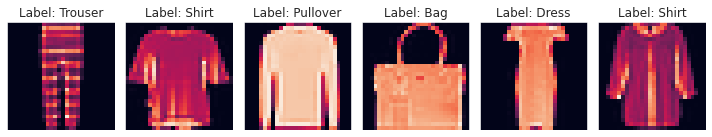

In [72]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,6),axes.flat):
    img,label=images[i],labels[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Label: {classes[label]}")

plt.tight_layout()
plt.show()

# Defining the Convolutional Neural Network

<img src='https://drive.google.com/uc?id=1Euy5_bGIiiYECSZUeEofgTImJWgQ0XLf'>

**<h2>Implement the model above in pytorch</h2>**

In [73]:
import torch.nn as nn
import torch.nn.functional as F

#define the CNN architecture below
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x



#################################################################################
#                                   THE END                                     #
#################################################################################
        
        
    def forward(self, x):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
#################################################################################
#                                   THE END                                     #
#################################################################################
        
        return x

In [74]:
# Using GPU if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [75]:
cnn_model = Net()
cnn_model.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

# Defining Loss Function and optimizer
**Define appropriate Loss Function, Optimizer and Learning Rate**

In [76]:
import torch.optim as optim

Learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(cnn_model.parameters())

**Define number of epochs and path to save the best model**

In [77]:
epochs = 30
save_path="/content/cnn_model"

# Finally we will train our neural network

In [78]:
# multiclass accuracy
def multi_acc(y_pred, y_test):
    _, y_pred_tags = torch.max(y_pred, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

**Implementing the training algorithm and Saving the model with minimum Validation Loss**

In [79]:
# training loop
def train_model(model, train_dataloader, val_dataloader, n_epochs, optimizer, criterion, device, save_path):
    train_losses = []
    val_losses = []
    valid_loss_min = np.Inf 
    best_model = model

    for epoch in range(n_epochs):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
        ####### Training Phase ########
        model.train()
        with tqdm(train_dataloader, unit="batch") as batches:
            epoch_loss = 0
            count = 0
            for data, target in batches:
                batches.set_description(f"Epoch {epoch + 1}")

                # move to GPU
                data, target = data.to(device), target.to(device)
                data = Variable(data.view(150, 1, 28, 28))
                target = Variable(target)
                # train 

                out = model(data)
                train_loss = criterion(out, target)
                optimizer.zero_grad()

                train_loss.backward()
                optimizer.step()

                acc = multi_acc(out, target)
                batches.set_postfix(train_loss = train_loss.item(), train_accuracy = acc.item()) # show loss and accuracy per batch of data

                epoch_loss = epoch_loss + train_loss.item()
                count = count + 1

        train_losses.append(epoch_loss / count)


        ####### Validation Phase ########
        model.eval()
        accs = []
        with torch.no_grad():
            # run the prediction on the validation dataloader,
            y_true, y_pred = [], []
            valid_loss = 0
            count = 0
            for batch_idx, (data, target) in enumerate(val_dataloader):
                # move to GPU
                data, target = data.to(device), target.to(device)
                # validation
                out = model(data)
                acc = multi_acc(out, target)
                accs.append(acc.item())
                valid_loss = valid_loss + criterion(out, target)
                count = count + 1

        valid_loss = valid_loss / count

#################################################################################
#                                   THE END                                     #
#################################################################################
        val_losses.append(float(valid_loss.to("cpu")))
        
        # print validation statistics 
        print('Epoch: {}  Validation Loss: {:.6f} Validation Accuracy: {:.1f}'.format(epoch+1, valid_loss, sum(accs) / len(accs)))

        ## If the valiation loss has decreased, then saving the model
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            best_model = copy.deepcopy(model)
            valid_loss_min = valid_loss 

    return best_model, train_losses, val_losses

**Train the model**

In [80]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
trained_model, train_losses, val_losses = train_model(cnn_model, train_dataloader,
                                                      val_dataloader, epochs, optimizer,
                                                      criterion, device, save_path)
#################################################################################
#                                   THE END                                     #
#################################################################################

Epoch 1: 100%|██████████| 320/320 [00:10<00:00, 31.93batch/s, train_accuracy=77, train_loss=0.672]


Epoch: 1  Validation Loss: 0.420132 Validation Accuracy: 83.8
Validation loss decreased (inf --> 0.420132).  Saving model ...


Epoch 2: 100%|██████████| 320/320 [00:09<00:00, 32.45batch/s, train_accuracy=80, train_loss=0.574]


Epoch: 2  Validation Loss: 0.355737 Validation Accuracy: 86.5
Validation loss decreased (0.420132 --> 0.355737).  Saving model ...


Epoch 3: 100%|██████████| 320/320 [00:09<00:00, 32.37batch/s, train_accuracy=85, train_loss=0.466]


Epoch: 3  Validation Loss: 0.329065 Validation Accuracy: 87.4
Validation loss decreased (0.355737 --> 0.329065).  Saving model ...


Epoch 4: 100%|██████████| 320/320 [00:10<00:00, 31.75batch/s, train_accuracy=89, train_loss=0.378]


Epoch: 4  Validation Loss: 0.304414 Validation Accuracy: 88.5
Validation loss decreased (0.329065 --> 0.304414).  Saving model ...


Epoch 5: 100%|██████████| 320/320 [00:10<00:00, 30.70batch/s, train_accuracy=85, train_loss=0.406]


Epoch: 5  Validation Loss: 0.288108 Validation Accuracy: 89.2
Validation loss decreased (0.304414 --> 0.288108).  Saving model ...


Epoch 6: 100%|██████████| 320/320 [00:10<00:00, 31.81batch/s, train_accuracy=87, train_loss=0.396]


Epoch: 6  Validation Loss: 0.278290 Validation Accuracy: 89.6
Validation loss decreased (0.288108 --> 0.278290).  Saving model ...


Epoch 7: 100%|██████████| 320/320 [00:09<00:00, 32.97batch/s, train_accuracy=86, train_loss=0.351]


Epoch: 7  Validation Loss: 0.265500 Validation Accuracy: 89.9
Validation loss decreased (0.278290 --> 0.265500).  Saving model ...


Epoch 8: 100%|██████████| 320/320 [00:09<00:00, 33.50batch/s, train_accuracy=87, train_loss=0.377]


Epoch: 8  Validation Loss: 0.260904 Validation Accuracy: 90.1
Validation loss decreased (0.265500 --> 0.260904).  Saving model ...


Epoch 9: 100%|██████████| 320/320 [00:10<00:00, 31.09batch/s, train_accuracy=89, train_loss=0.307]


Epoch: 9  Validation Loss: 0.251146 Validation Accuracy: 90.5
Validation loss decreased (0.260904 --> 0.251146).  Saving model ...


Epoch 10: 100%|██████████| 320/320 [00:09<00:00, 34.12batch/s, train_accuracy=89, train_loss=0.283]


Epoch: 10  Validation Loss: 0.251433 Validation Accuracy: 90.8


Epoch 11: 100%|██████████| 320/320 [00:09<00:00, 34.15batch/s, train_accuracy=93, train_loss=0.255]


Epoch: 11  Validation Loss: 0.240764 Validation Accuracy: 91.1
Validation loss decreased (0.251146 --> 0.240764).  Saving model ...


Epoch 12: 100%|██████████| 320/320 [00:09<00:00, 33.90batch/s, train_accuracy=88, train_loss=0.419]


Epoch: 12  Validation Loss: 0.233397 Validation Accuracy: 91.7
Validation loss decreased (0.240764 --> 0.233397).  Saving model ...


Epoch 13: 100%|██████████| 320/320 [00:10<00:00, 31.70batch/s, train_accuracy=91, train_loss=0.255]


Epoch: 13  Validation Loss: 0.231854 Validation Accuracy: 91.7
Validation loss decreased (0.233397 --> 0.231854).  Saving model ...


Epoch 14: 100%|██████████| 320/320 [00:09<00:00, 32.17batch/s, train_accuracy=89, train_loss=0.307]


Epoch: 14  Validation Loss: 0.229399 Validation Accuracy: 91.6
Validation loss decreased (0.231854 --> 0.229399).  Saving model ...


Epoch 15: 100%|██████████| 320/320 [00:10<00:00, 31.68batch/s, train_accuracy=89, train_loss=0.272]


Epoch: 15  Validation Loss: 0.223063 Validation Accuracy: 91.7
Validation loss decreased (0.229399 --> 0.223063).  Saving model ...


Epoch 16: 100%|██████████| 320/320 [00:10<00:00, 30.48batch/s, train_accuracy=89, train_loss=0.315]


Epoch: 16  Validation Loss: 0.222870 Validation Accuracy: 91.9
Validation loss decreased (0.223063 --> 0.222870).  Saving model ...


Epoch 17: 100%|██████████| 320/320 [00:09<00:00, 32.20batch/s, train_accuracy=92, train_loss=0.217]


Epoch: 17  Validation Loss: 0.221636 Validation Accuracy: 92.1
Validation loss decreased (0.222870 --> 0.221636).  Saving model ...


Epoch 18: 100%|██████████| 320/320 [00:09<00:00, 32.33batch/s, train_accuracy=90, train_loss=0.263]


Epoch: 18  Validation Loss: 0.218827 Validation Accuracy: 92.1
Validation loss decreased (0.221636 --> 0.218827).  Saving model ...


Epoch 19: 100%|██████████| 320/320 [00:09<00:00, 32.25batch/s, train_accuracy=92, train_loss=0.211]


Epoch: 19  Validation Loss: 0.215021 Validation Accuracy: 92.2
Validation loss decreased (0.218827 --> 0.215021).  Saving model ...


Epoch 20: 100%|██████████| 320/320 [00:09<00:00, 32.72batch/s, train_accuracy=93, train_loss=0.217]


Epoch: 20  Validation Loss: 0.218222 Validation Accuracy: 92.0


Epoch 21: 100%|██████████| 320/320 [00:10<00:00, 31.32batch/s, train_accuracy=91, train_loss=0.26]


Epoch: 21  Validation Loss: 0.213596 Validation Accuracy: 92.3
Validation loss decreased (0.215021 --> 0.213596).  Saving model ...


Epoch 22: 100%|██████████| 320/320 [00:10<00:00, 30.44batch/s, train_accuracy=89, train_loss=0.237]


Epoch: 22  Validation Loss: 0.212405 Validation Accuracy: 92.6
Validation loss decreased (0.213596 --> 0.212405).  Saving model ...


Epoch 23: 100%|██████████| 320/320 [00:10<00:00, 31.78batch/s, train_accuracy=93, train_loss=0.187]


Epoch: 23  Validation Loss: 0.216311 Validation Accuracy: 92.2


Epoch 24: 100%|██████████| 320/320 [00:09<00:00, 32.40batch/s, train_accuracy=91, train_loss=0.269]


Epoch: 24  Validation Loss: 0.208365 Validation Accuracy: 92.7
Validation loss decreased (0.212405 --> 0.208365).  Saving model ...


Epoch 25: 100%|██████████| 320/320 [00:09<00:00, 32.04batch/s, train_accuracy=89, train_loss=0.326]


Epoch: 25  Validation Loss: 0.209829 Validation Accuracy: 92.4


Epoch 26: 100%|██████████| 320/320 [00:09<00:00, 32.38batch/s, train_accuracy=91, train_loss=0.209]


Epoch: 26  Validation Loss: 0.209665 Validation Accuracy: 92.6


Epoch 27: 100%|██████████| 320/320 [00:09<00:00, 33.11batch/s, train_accuracy=92, train_loss=0.209]


Epoch: 27  Validation Loss: 0.206234 Validation Accuracy: 92.7
Validation loss decreased (0.208365 --> 0.206234).  Saving model ...


Epoch 28: 100%|██████████| 320/320 [00:09<00:00, 33.49batch/s, train_accuracy=92, train_loss=0.196]


Epoch: 28  Validation Loss: 0.206528 Validation Accuracy: 92.6


Epoch 29: 100%|██████████| 320/320 [00:09<00:00, 33.06batch/s, train_accuracy=94, train_loss=0.165]


Epoch: 29  Validation Loss: 0.207630 Validation Accuracy: 92.6


Epoch 30: 100%|██████████| 320/320 [00:09<00:00, 32.92batch/s, train_accuracy=91, train_loss=0.222]


Epoch: 30  Validation Loss: 0.206841 Validation Accuracy: 92.7


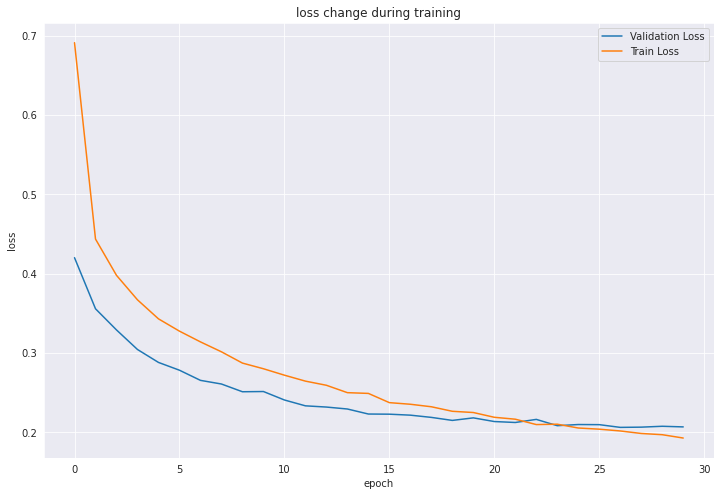

In [81]:
# plot losses
plt.subplots(figsize=(12, 8))
sns.set_style("dark")
sns.lineplot(data=val_losses,label="Validation Loss")
sns.lineplot(data=np.asarray(train_losses),label="Train Loss").set(title="loss change during training", xlabel="epoch", ylabel="loss")
plt.legend()
plt.grid()
plt.show()

# Prediction on Test Data

In [82]:
def predict(images, model):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
    images = images.to(device)
    y_pred = model(images)
    _, y_pred_tags = torch.max(y_pred, dim = 1) 
#################################################################################
#                                   THE END                                     #
#################################################################################  
    return y_pred_tags

**Accuracy Result on Test Data**

In [83]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

predictions_list = []
labels_list = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = trained_model(test)
        predicted = torch.max(outputs, 1)[1]
        predictions_list.append(predicted)
        labels_list.append(labels)
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format({classes[i]}, class_correct[i] * 100 / total_correct[i]))

from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

Accuracy of {'T-shirt/top'}: 83.26%
Accuracy of {'Trouser'}: 98.21%
Accuracy of {'Pullover'}: 89.97%
Accuracy of {'Dress'}: 93.52%
Accuracy of {'Coat'}: 84.79%
Accuracy of {'Sandal'}: 98.17%
Accuracy of {'Shirt'}: 76.78%
Accuracy of {'Sneaker'}: 98.13%
Accuracy of {'Bag'}: 98.54%
Accuracy of {'Ankle boot'}: 96.70%


**Classification report**

In [84]:
print(classification_report(predictions_l, labels_l, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.89      0.87       955
     Trouser       0.98      1.00      0.99       987
    Pullover       0.89      0.86      0.88      1031
       Dress       0.94      0.91      0.92      1025
        Coat       0.86      0.87      0.87       987
      Sandal       0.98      0.99      0.98       995
       Shirt       0.77      0.76      0.76      1009
     Sneaker       0.98      0.95      0.96      1034
         Bag       0.99      0.98      0.99      1004
  Ankle boot       0.96      0.98      0.97       973

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



**Displaying a random set of images from test data**

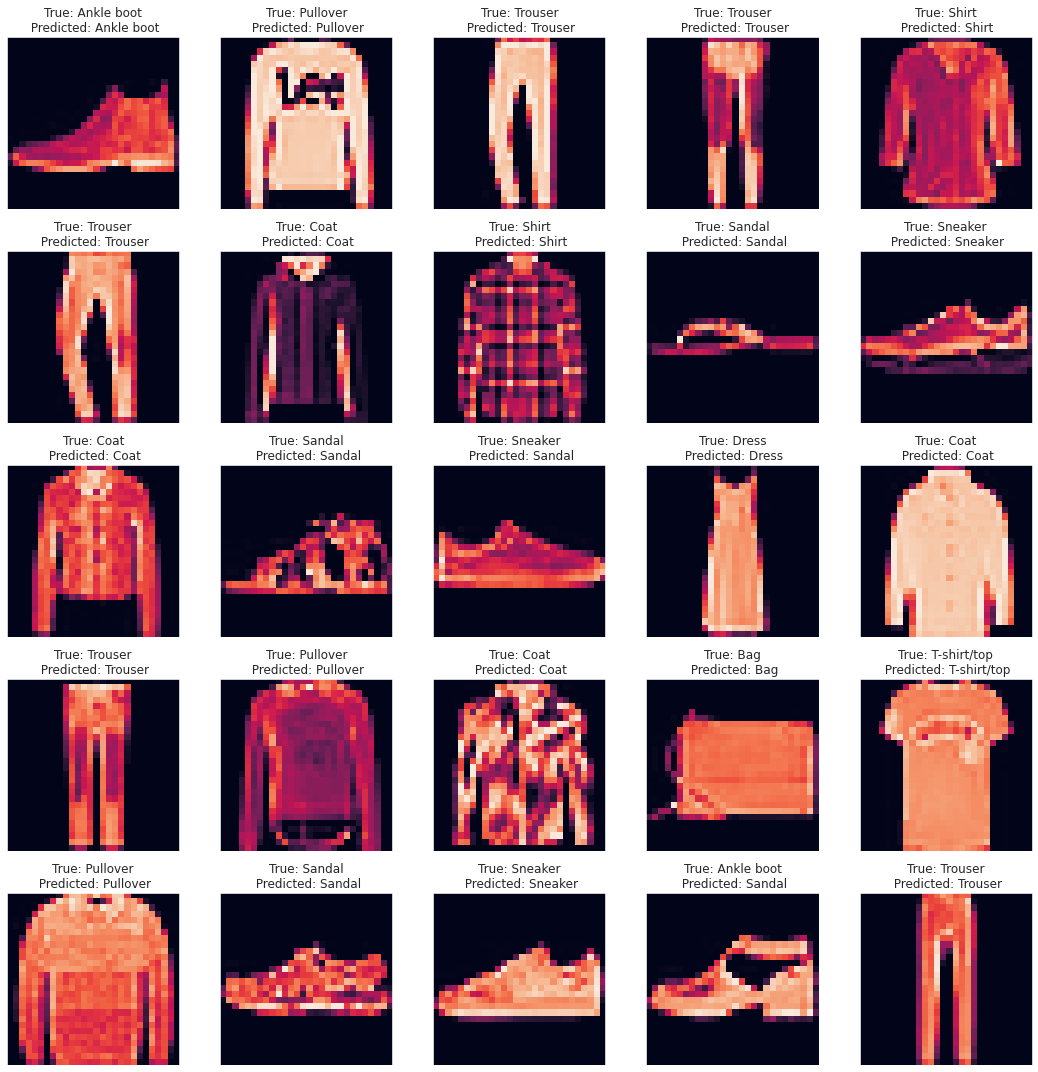

In [85]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
predicted=predict(images,cnn_model)

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,25),axes.flat):
    img,label=images[i],labels[i]
    pred=predicted[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"True: {classes[label]}\n Predicted: {classes[pred]}")

plt.tight_layout()
plt.show()